# Part III. xbatcher

**Author:** Eli Holmes (NOAA)

[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/ocean-satellite-tools/mind-the-chl-gap/blob/main/book/notebooks/CHL_prediction_CNN_Part_3.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link]

[download-link]: https://ocean-satellite-tools.github.io/mind-the-chl-gap/_static/CHL_prediction_CNN_Part_3.ipynb
[colab-link]: https://colab.research.google.com/github/ocean-satellite-tools/mind-the-chl-gap/blob/main/book/notebooks/CHL_prediction_CNN_Part_3.ipynb
[jupyter-link]: https://nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/ocean-satellite-tools/mind-the-chl-gap/main/book/notebooks/CHL_prediction_CNN_Part_3.ipynb

::: {.callout-note}
# Run this with GPU

You can run in Colab if you don't have GPU access. Click the "Open in Colab" button above. Sign in with a Google Account. You get like 100 hours of compute a month for free.

To get GPU in Colab, go to Edit > Notebook Settings  and select GPU. Then uncomment the `!pip` line below to install the needed libraries.
:::

## What is `xbatcher`?

`xbatcher` is a Python library that efficiently generates mini-batches from large `xarray` datasets. It allows you to stream spatial and temporal patches directly from Dask-backed data into machine learning models without needing to load everything into memory.

When we are interacting with data in a cloud bucket, we want to study the chunking of the data so that we minimize the I/O load. Hopefully, the data are chunked (into files) in such a way that we are not accessing a lot of files. Perferably we want to be doing as little I/O (file reading) as we can while still not running out of memory.

### Key Elements of Using `xbatcher`

* Batch Generator to get little xarrays
* Function to turn the little xarrays into numpy arrays
* Link to TensorFlow


**1. A Batch Generator**  

You create a generator that yields individual samples (as little xarray Datasets) from the full dataset. It needs to know the size of batches and overlap.

Example:  
`input_dims = {"time": 20, "lat": 64, "lon": 64}`  
Each sample will have shape `(20, 64, 64)` before stacking variables. Unfortunately, I chunked the Zarr file in 100 day chunks, so using 20 day chunks in xbatches means I have to download a lot more data (80 extra days) than I want, but my validation data had 37 days so I am limited by that.

`input_overlap` controls the amount of overlap between samples along each dimension. Often set to 0 (like I am), but including overlap can help reduce edge effects in CNNs.


```python
from xbatcher import BatchGenerator

train_gen = BatchGenerator(
    dataset[input_vars + output_vars],
    input_dims=input_dims,
    input_overlap=input_overlap
)
```

**2. Create a function to give numpy arrays from your batches (little xarrays)**

By default, xarray and dask use lazy, chunked arrays (e.g., dask.array or xarray.DataArray). TensorFlow cannot ingest those directly — it needs fully materialized data per training sample.

TensorFlow's from_generator expects the generator to yield concrete values, typically as `np.ndarray (NumPy arrays)` (though other formats are possible that can convert to `tf.Tensor`).

Here is our little function that takes a batch (little xarray) and returns a stacked numpy array.

```python
def train_gen_tf_batches():
    for batch in train_gen:
        time_len = batch["y"].sizes["time"]
        for t in range(time_len):
            x = np.stack([
                batch[var].isel(time=t).data if "time" in batch[var].dims else batch[var].data
                for var in input_vars
            ], axis=-1).astype(np.float32)  # (xx, xx, n_features)
            y = batch["y"].isel(time=t).data[..., np.newaxis].astype(np.float32)  # (xx, xx, 1)
            yield x, y
```

**5. Integration with TensorFlow**

Wraps the generator into a TensorFlow pipeline, so it can:

* Automatically batch and prefetch data,
* Stream from disk or cloud lazily (via Dask)
* Integrate with `model.fit()`

```python
train_dataset = train_dataset.shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
```

::: {.callout-note}
# Tip for JupyterHubs

If you are on the JupyterHub it is wise to shutdown all the kernels before running the code to make sure you don't run out of memory.

Kernel > Shutdown All Kernels
:::

## Load the libraries

In [ ]:
# Colab Users!!!
# Uncomment the pip line below and run if you are in Colab
# Leave in the !. That is part of the cmd
# !pip install zarr gcsfs xbatcher --quiet

In [156]:
# --- Core data handling libraries ---
import xarray as xr       # for working with labeled multi-dimensional arrays
import numpy as np        # for numerical operations on arrays
import dask.array as da   # for lazy, parallel array operations (used in xarray backends)

# --- Plotting ---
import matplotlib.pyplot as plt  # for creating plots

import xbatcher

# --- TensorFlow setup ---
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # suppress TensorFlow log spam (0=all, 3=only errors)

import tensorflow as tf  # main deep learning framework

# --- Keras (part of TensorFlow): building and training neural networks ---
from keras.models import Sequential          # lets us stack layers in a simple linear model
from keras.layers import Conv2D              # 2D convolution layer — finds spatial patterns in image-like data
from keras.layers import BatchNormalization  # stabilizes and speeds up training by normalizing activations
from keras.layers import Dropout             # randomly "drops" neurons during training to reduce overfitting
from keras.callbacks import EarlyStopping    # stops training early if validation loss doesn't improve

## See what machine we are on

In [157]:
# list all the physical devices
physical_devices = tf.config.list_physical_devices()
print("All Physical Devices:", physical_devices)

# list all the available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Print infomation for available GPU if there exists any
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print("GPU Details:", details)
else:
    print("No GPU available")

All Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Details: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


# Load data

I created the data for Part I in `Data_Prep_Part_2`. Here I will load.

- sst, so, sin_time, cos_time
- ocean_mask
- y (CHL)

### `open_dataset` versus `open_zarr`

The data in the Google Object Storage is a chunked Zarr file. It has files that are chunks of 100 days of data. When we go to get data we will get these files. To do this efficiently, our xarray dataset needs to know what these chunks are. How we load our data will determine if our xarray dataset "knows" about the chunks and this will make a big difference to speed and memory usage. 

`open_dataset` will load our data but it won't be dask arrays. So when we do computations, the dask machinary to do chunked processing will not be triggered. Effectively all the needed data (in this case 2020) will be loaded into memory. You will see that memory usage is high in this example. This is ok if all the training data can fit into memory. This will be the fastest approach.

In [9]:
# load full dataset 1997 to 2022 from Google bucket
dataset_od = xr.open_dataset(
    "gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/cnn_tutorial",
    engine="zarr",
    backend_kwargs={"storage_options": {"token": "anon"}},
    consolidated=True
)
# nothing; no chunking
dataset_od.sel(time="2020")["sst"].chunks

`open_zarr` will load our data with the chunking information. Our variables will be dask arrays. When we do computations, the dask machinary to do chunked processing **will** be triggered. This will create a lot of CPU overhead as dask figures out how best to get the chunks. This means it will be slower; in the case of our example, about 5x slower. But it will be memory efficient. The needed data for a batch will be loaded and then released.

::: {.callout-note}
# Does it matter how we chunk the data?

Yes! Each chunk is a file. Loading in files is very slow even if the files are small. We need to balance files loaded versus memory to load data into memory. I found that chunks of 100 days worked pretty well while 1 day chunks didn't work at all (too slow). Although technically I can load a full year into memory and that is fastest, I need to use chunking and the dask machinery if I am going to scale up to training on many years of data. When I train on many years, I cannot load all the data into memory.
:::

In [158]:
# load full dataset 1997 to 2022 from Google bucket
# chunked into 100 day chunks (64, 64 lat/lon)
dataset_oz = xr.open_zarr(
    "gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/cnn_tutorial", 
    storage_options={"token": "anon"}, 
    consolidated=True
)
# chunked; some are partial
dataset_oz.sel(time="2020")["sst"].chunks

((89, 100, 100, 77), (64, 64, 21), (64, 64, 53))

In [159]:
# will use the chunked data because we are going to use that for bigger data
dataset = dataset_oz
dataset

<xarray.Dataset> Size: 5GB
Dimensions:     (time: 9207, lat: 149, lon: 181)
Coordinates:
  * lat         (lat) float32 596B 32.0 31.75 31.5 31.25 ... -4.5 -4.75 -5.0
  * lon         (lon) float32 724B 45.0 45.25 45.5 45.75 ... 89.5 89.75 90.0
  * time        (time) datetime64[ns] 74kB 1997-10-01 1997-10-02 ... 2022-12-31
Data variables:
    cos_time    (time, lat, lon) float32 993MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    ocean_mask  (lat, lon) float32 108kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    sin_time    (time, lat, lon) float32 993MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    so          (time, lat, lon) float32 993MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    sst         (time, lat, lon) float32 993MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>
    topo        (lat, lon) float32 108kB dask.array<chunksize=(64, 64), meta=np.ndarray>
    y           (time, lat, lon) float32 993MB dask.array<chunksize=(100, 64, 64), meta=np.ndarray>

## Set up our train, validation and test datasets for xbatcher

xbatcher requires that we return xarray Datasets, like `dataset` above, with our input variables (`sst`, `so`, etc) and `y` ready for sending to TensorFlow. 

In [160]:
import numpy as np
import dask.array as da
import xarray as xr

def time_series_split_for_xbatcher(
    data, num_var, cat_var=None, split_ratio=(0.7, 0.2, 0.1), seed=42,
    X_mean=None, X_std=None
):
    """
    Splits time indices randomly into train/val/test for xbatcher.
    Replaces NaNs, and normalizes numerical variables if mean/std are provided.

    Parameters:
        data: xarray.Dataset with 'time' dimension
        num_var: list of numerical variable names
        cat_var: list of categorical variable names (no normalization)
        split_ratio: tuple of train, val, test split ratios
        seed: random seed
        X_mean, X_std: optional normalization stats

    Returns:
        train_ds, val_ds, test_ds: xarray datasets ready for xbatcher
        X_mean, X_std: used for normalization (or None, None if not applied)
    """
    if cat_var is None:
        cat_var = []
    input_var = num_var + cat_var
    output_var = ["y"]

    time_dim = "time"
    if time_dim not in data.dims:
        raise ValueError("Dataset must contain a 'time' dimension.")

    time_len = data.sizes[time_dim]
    rng = np.random.default_rng(seed)
    all_indices = rng.choice(time_len, size=time_len, replace=False)

    train_end = int(split_ratio[0] * time_len)
    val_end = int((split_ratio[0] + split_ratio[1]) * time_len)
    train_idx = np.sort(all_indices[:train_end])
    val_idx = np.sort(all_indices[train_end:val_end])
    test_idx = np.sort(all_indices[val_end:])

    train_data = data.isel(time=train_idx)

    # Compute normalization stats if not provided
    if num_var:
        if X_mean is None or X_std is None:
            stacked = da.stack([train_data[v].data for v in num_var], axis=-1)
            X_mean = da.nanmean(stacked, axis=(0, 1, 2)).compute()
            X_std = da.nanstd(stacked, axis=(0, 1, 2)).compute()
        X_std_safe = da.where(X_std == 0, 1.0, X_std)

    def normalize_and_fill(ds):
        ds_copy = ds.copy()
        for i, var in enumerate(num_var):
            v = (ds[var] - X_mean[i]) / X_std_safe[i]
            ds_copy[var] = xr.DataArray(
                da.nan_to_num(v.data), dims=ds[var].dims, coords=ds[var].coords
            )
        for var in cat_var + output_var:
            ds_copy[var] = xr.DataArray(
                da.nan_to_num(ds[var].data), dims=ds[var].dims, coords=ds[var].coords
            )
        return ds_copy

    train_ds = normalize_and_fill(data.isel(time=train_idx))
    val_ds = normalize_and_fill(data.isel(time=val_idx))
    test_ds = normalize_and_fill(data.isel(time=test_idx))
    full_ds = normalize_and_fill(data)

    return train_ds, val_ds, test_ds, full_ds, X_mean, X_std


## Set up xbatcher

In [161]:
from xbatcher import BatchGenerator

# Define variables
input_vars = ["sst", "so", "sin_time", "cos_time", "ocean_mask"]
output_vars = ["y"]
num_var = ["sst", "so"]
cat_var = ["sin_time", "cos_time", "ocean_mask"]

# Use the whole field
input_dims = {"time": 30, "lat": 149, "lon": 181}
input_overlap = {"time": 0, "lat": 0, "lon": 0}

# Split the dataset using your function
train_ds, val_ds, test_ds, full_ds, X_mean_used, X_std_used = time_series_split_for_xbatcher(
    data=dataset.sel(time="2020"),
    num_var=num_var,
    cat_var=cat_var,
)

# Create batch generators
train_gen = BatchGenerator(train_ds[input_vars + output_vars], input_dims=input_dims, input_overlap=input_overlap)
val_gen = BatchGenerator(val_ds[input_vars + output_vars], input_dims=input_dims, input_overlap=input_overlap)
test_gen = BatchGenerator(test_ds[input_vars + output_vars], input_dims=input_dims, input_overlap=input_overlap)

In [162]:
X_mean

array([301.79614 ,  35.002277], dtype=float32)

## Set up generator functions to create numpy arrays

In [163]:
# Generator: yield individual time slices for batches
input_shape = (input_dims["lat"], input_dims["lon"], len(input_vars))
output_shape = (input_dims["lat"], input_dims["lon"], 1)

def train_gen_tf_batches():
    for batch in train_gen:
        time_len = batch["y"].sizes["time"]
        for t in range(time_len):
            x = np.stack([
                batch[var].isel(time=t).data if "time" in batch[var].dims else batch[var].data
                for var in input_vars
            ], axis=-1).astype(np.float32)  # (xx, xx, n_features)
            y = batch["y"].isel(time=t).data[..., np.newaxis].astype(np.float32)  # (xx, xx, 1)
            yield x, y

def val_gen_tf_batches():
    for batch in val_gen:
        time_len = batch["y"].sizes["time"]
        for t in range(time_len):
            x = np.stack([
                batch[var].isel(time=t).data if "time" in batch[var].dims else batch[var].data
                for var in input_vars
            ], axis=-1).astype(np.float32)
            y = batch["y"].isel(time=t).data[..., np.newaxis].astype(np.float32)
            yield x, y


train_dataset_from_gen = tf.data.Dataset.from_generator(
    train_gen_tf_batches,
    output_signature=(
        tf.TensorSpec(shape=input_shape, dtype=tf.float32),
        tf.TensorSpec(shape=output_shape, dtype=tf.float32),
    )
)

val_dataset_from_gen = tf.data.Dataset.from_generator(
    val_gen_tf_batches,
    output_signature=(
        tf.TensorSpec(shape=input_shape, dtype=tf.float32),
        tf.TensorSpec(shape=output_shape, dtype=tf.float32),
    )
)

### Final prep of dataset for TensorFlow

We are not trying to preserve temporal information since we are predicting chlorophyll from same day SST and salinity. So we shuffle() to make sure that everything is i.i.d. for TensorFlow.

* shuffle() adds randomness within the training batches
* Prevents batch-to-batch correlation
* Improves model convergence and generalization

The max shuffle would be the length of the training data per batch up to about 1000-2000. But if the dataset if very large, that would be a lot of overhead and not necessary. In the pper end 10 x number of batches. In our case, the generator yields one sample per time step, so the total training samples ≈ `len(train_gen) × input_dims["time"]`

In [8]:
print("Number of batches in training set:", len(train_gen))
print("Max shuffle size:", len(train_gen) * input_dims["time"])

Number of batches in training set: 12
Max shuffle size: 240


Using `.repeat()`. I had to add this when using a generator and specify the training steps per batch. Otherwise, TensorFlow was struggling during the first pass to figure out how much data to use and wasn't resetting the generator (to give a new set of data) properly.

In [164]:
# you might need to tweak this
BATCH_SIZE = 8
SHUFFLE_N = 100
train_dataset = train_dataset_from_gen.shuffle(SHUFFLE_N).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset_from_gen.batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)


In [165]:
%%time
# check that shape is (BATCH_SIZE, 149, 181, 5)
for x, y in train_dataset.take(1):
    print("Train x shape:", x.shape)
    print("Train y shape:", y.shape)

Train x shape: (8, 149, 181, 5)
Train y shape: (8, 149, 181, 1)
CPU times: user 2.22 s, sys: 353 ms, total: 2.57 s
Wall time: 2.4 s


## Let's build the model

We build a simple 3-layer CNN model. Each layer preserves the (lat, lon) shape and learns filters to extract spatial patterns. 

In [166]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, BatchNormalization, Dropout

def create_model_CNN(input_shape):
    """
    Create a simple 3-layer CNN model for gridded ocean data.

    Parameters
    ----------
    input_shape : tuple
        The shape of each sample, e.g., (149, 181, 2)

    Returns
    -------
    model : keras.Model
        CNN model to predict CHL from SST and salinity
    """
    model = Sequential()

    # Input layer defines the input dimensions for the CNN
    model.add(Input(shape=input_shape))

    # Layer 1 — learns fine-scale 3x3 spatial features
    # Let the model learn 64 different patterns (filters) in the data at this layer.
    # activation relu is non-linearity
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Layer 2 — expands context to 5x5; combines fine features into larger structures
    # Reduce the number of patterns (filters) so we gradually reduce model complexity
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Layer 3 — has access to ~7x7 neighborhood; outputs CHL prediction per pixel
    # Combines all the previous layer’s features into a CHL estimate at each pixel
    # 1 response (chl) — hence, 1 prediction pixel = filter
    # linear since predicting a real continuous variable (log CHL)
    model.add(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='linear'))

    return model

## Let's train the model

### What is an Epoch?

An **epoch** is **one full pass** through the entire training dataset. Each step is a day since model is trained one day at a time. Number of steps (days) in an epoch is (training days) / number of batches.

## What Happens in One Epoch?

### 1. **Training Phase** (`train_dataset`)

- TensorFlow iterates over batches from `train_dataset`.
- For each batch:
  - Performs a **forward pass** (makes predictions),
  - Computes the **loss** (e.g., Mean Absolute Error),
  - Runs a **backward pass** (computes gradients),
  - **Updates weights** using the optimizer (e.g., Adam).

### 2. **Validation Phase** (`val_dataset`)

- After all training batches are processed in the epoch:
  - The model is **evaluated** on `val_dataset`.
  - This step **does not update weights**.
- Metrics like `val_loss` and `val_mae` are calculated to monitor performance on unseen data.

## Why Use `val_dataset`?

- The validation dataset **does not participate in training**.
- It provides a **consistent benchmark** at the end of each epoch.
- It's used to:
  - Track **overfitting** (if validation loss starts increasing),
  - Support callbacks like `EarlyStopping`,
  - Save **best model checkpoints** during training.

In [167]:
model = create_model_CNN(input_shape)
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(
    patience=10,              # Stop if validation loss doesn't improve for 10 epochs
    restore_best_weights=True  # Revert to the model weights from the best epoch
)

TRAIN_STEPS_PER_EPOCH = len(train_gen) * input_dims["time"] // BATCH_SIZE
VAL_STEPS_PER_EPOCH = len(val_gen) * input_dims["time"] // BATCH_SIZE

history = model.fit(
    train_dataset,
    epochs=50,                    # Maximum number of training epochs
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    validation_data=val_dataset, # Use validation data during training
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[early_stop],      # Stop early if no improvement
)

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 197ms/step - loss: 1.2570 - mae: 1.2570 - val_loss: 0.8432 - val_mae: 0.8432
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - loss: 0.8724 - mae: 0.8724 - val_loss: 0.6911 - val_mae: 0.6911
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 0.5442 - mae: 0.5442 - val_loss: 0.7178 - val_mae: 0.7178
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - loss: 0.4325 - mae: 0.4325 - val_loss: 0.6082 - val_mae: 0.6082
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.3795 - mae: 0.3795 - val_loss: 0.5682 - val_mae: 0.5682
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.3577 - mae: 0.3577 - val_loss: 0.5128 - val_mae: 0.5128
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - loss: 0.3387 - mae: 0.3387 - val_loss: 0.4746 - val_mae: 0.4746
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - loss: 0.3216 - mae: 0.3216 - val_loss: 0.4448 - val_mae: 0.4448
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0

## Plot training & validation loss values

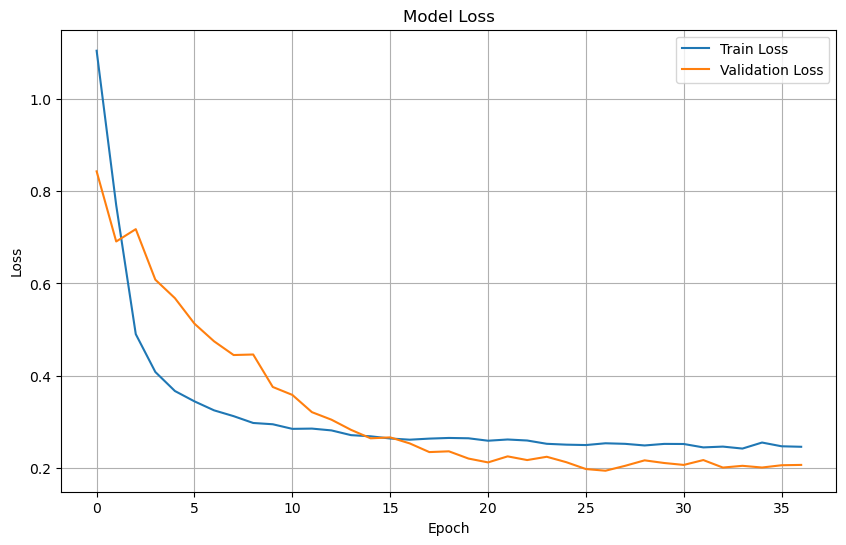

In [168]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Make some maps of our predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


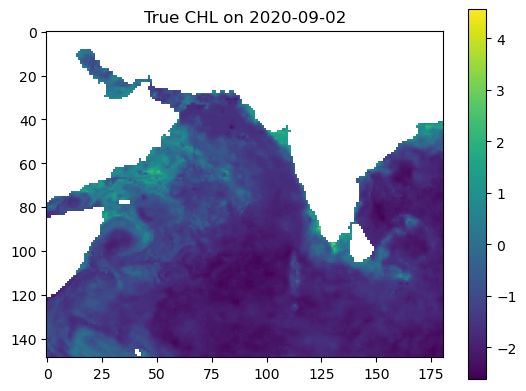

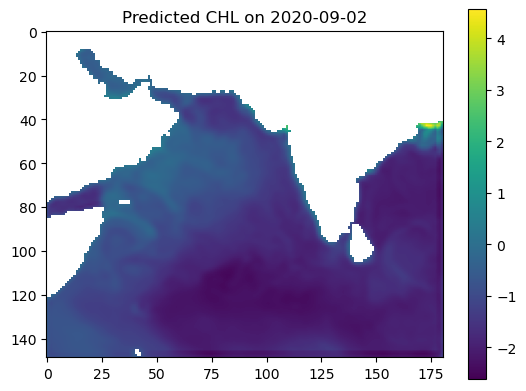

In [169]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Example: date to predict
date_to_predict = np.datetime64("2020-09-02")

# Extract dataset slice for this time
ds_at_time = full_ds.sel(time=date_to_predict)

# Prepare input (shape = [lat, lon, n_features])
input_data = np.stack([
    ds_at_time[var].values for var in input_vars
], axis=-1)  # shape = (lat, lon, n_features)

# Add batch dimension
input_data = input_data[np.newaxis, ...]  # shape = (1, lat, lon, n_features)

# Predict
predicted_output = model.predict(input_data)[0, ..., 0]  # shape = (lat, lon)

# True value from y
true_output = ds_at_time["y"].values  # shape = (lat, lon)

# Mask land (land_mask = ~ocean)
land_mask = ~dataset["ocean_mask"].values.astype(bool)
predicted_output[land_mask] = np.nan
true_output[land_mask] = np.nan

# Plot
vmin = np.nanmin([true_output, predicted_output])
vmax = np.nanmax([true_output, predicted_output])

plt.imshow(true_output, vmin=vmin, vmax=vmax, cmap='viridis')
plt.colorbar()
plt.title(f"True CHL on {date_to_predict}")
plt.show()

plt.imshow(predicted_output, vmin=vmin, vmax=vmax, cmap='viridis')
plt.colorbar()
plt.title(f"Predicted CHL on {date_to_predict}")
plt.show()



### Let's look at all the months

I will create a function to do this.

In [170]:
import numpy as np
import matplotlib.pyplot as plt

def plot_true_vs_predicted(data, year, model, X_mean, X_std, num_var, cat_var):
    """
    Plot true vs predicted output for first available day of each month in data_test.

    Parameters:
        data (xarray.Dataset): Contains variables 'y', 'ocean_mask', and coords 'lat', 'lon', 'time'
        year (string in format XXXX): The year to use.
        model (tf.keras.Model): Trained model with a .predict() method
        X_mean (np.ndarray): mean from the model training data (num_vars only)
        X_std (np.ndarray): std from the model training data
        num_var (np.ndarry): The variables to be standardized with `X_mean` and `X_std`
        cat_var (np.ndarry): The variables to be included in X, y but not standardized.
    """
    # Split the dataset to get full_ds
    _, _, _, year_ds, _, _ = time_series_split_for_xbatcher(
        data=data.sel(time=year),
        num_var=num_var,
        cat_var=cat_var,
        X_mean=X_mean,
        X_std=X_std,
    )

    # Get available time points and group by month
    available_dates = pd.to_datetime(year_ds.time.values)
    monthly_dates = (
        pd.Series(available_dates)
        .groupby([available_dates.year, available_dates.month])
        .min()
        .sort_values()
    )
    n_months = len(monthly_dates)

    # lat/lon info
    lat = year_ds.lat.values
    lon = year_ds.lon.values
    extent = [lon.min(), lon.max(), lat.min(), lat.max()]
    flip_lat = lat[0] > lat[-1]
    land_mask = ~year_ds["ocean_mask"].values.astype(bool)

    # Create figure and axes
    fig, axs = plt.subplots(n_months, 2, figsize=(7, 2 * n_months), constrained_layout=True)

    for i, date in enumerate(monthly_dates):
        # Select dataset for this date
        ds_at_time = year_ds.sel(time=np.datetime64(date))

        # Prepare model input: stack input variables into (lat, lon, n_features)
        input_data = np.stack([
            ds_at_time[var].values for var in input_vars
        ], axis=-1)

        # Predict: shape (lat, lon)
        predicted_output = model.predict(input_data[np.newaxis, ...])[0, ..., 0]

        # True output
        true_output = data["y"].sel(time=np.datetime64(date)).values

        # Mask land
        predicted_output[land_mask] = np.nan
        true_output[land_mask] = np.nan

        # Flip latitude if needed
        if flip_lat:
            true_output = np.flipud(true_output)
            predicted_output = np.flipud(predicted_output)

        # Shared color scale
        vmin = np.nanpercentile([true_output, predicted_output], 5)
        vmax = np.nanpercentile([true_output, predicted_output], 95)

        # Compute R²
        from sklearn.metrics import r2_score
        true_flat = true_output.flatten()
        pred_flat = predicted_output.flatten()
        valid_mask = ~np.isnan(true_flat) & ~np.isnan(pred_flat)
        r2 = r2_score(true_flat[valid_mask], pred_flat[valid_mask])

        # Plot true
        axs[i, 0].imshow(true_output, origin='lower', extent=extent,
                         vmin=vmin, vmax=vmax, cmap='viridis',
                         aspect='equal')
        axs[i, 0].set_title(f"{date.strftime('%b')} — True", fontsize=10)
        axs[i, 0].axis('off')

        # Plot predicted with R²
        axs[i, 1].imshow(predicted_output, origin='lower', extent=extent,
                         vmin=vmin, vmax=vmax, cmap='viridis', 
                         aspect='equal')
        axs[i, 1].set_title(f"{date.strftime('%b')} — Pred\n$R^2$ = {r2:.2f}", fontsize=10)
        axs[i, 1].axis('off')

    plt.suptitle(f'CHL: True vs Predicted (log scale) — {year}', fontsize=16)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


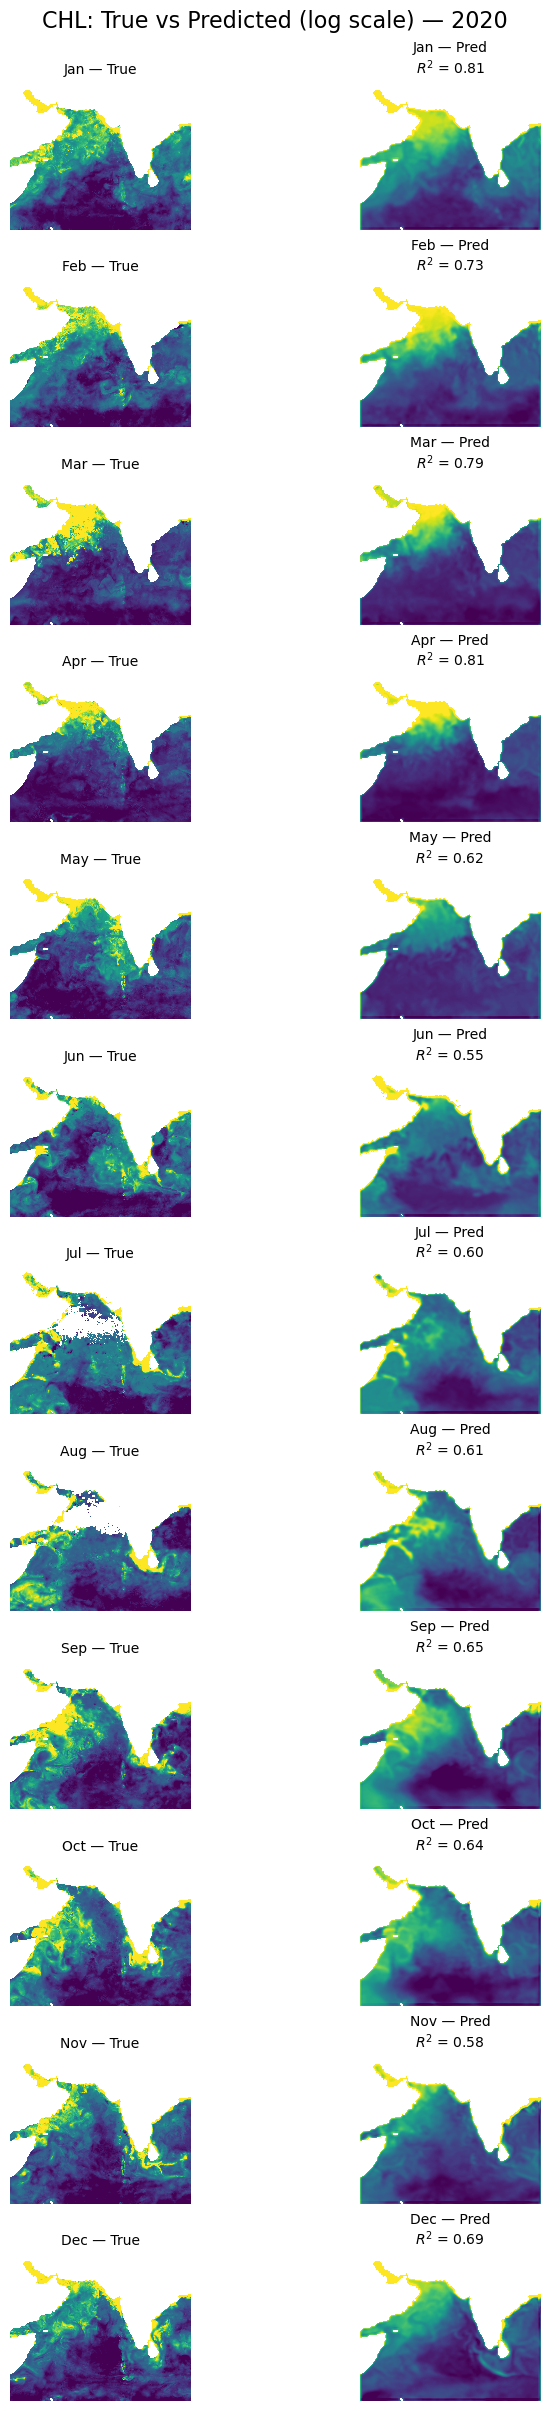

In [171]:
plot_true_vs_predicted(dataset, "2020", model, X_mean, X_std, num_var, cat_var)

### Let's look at a different year

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


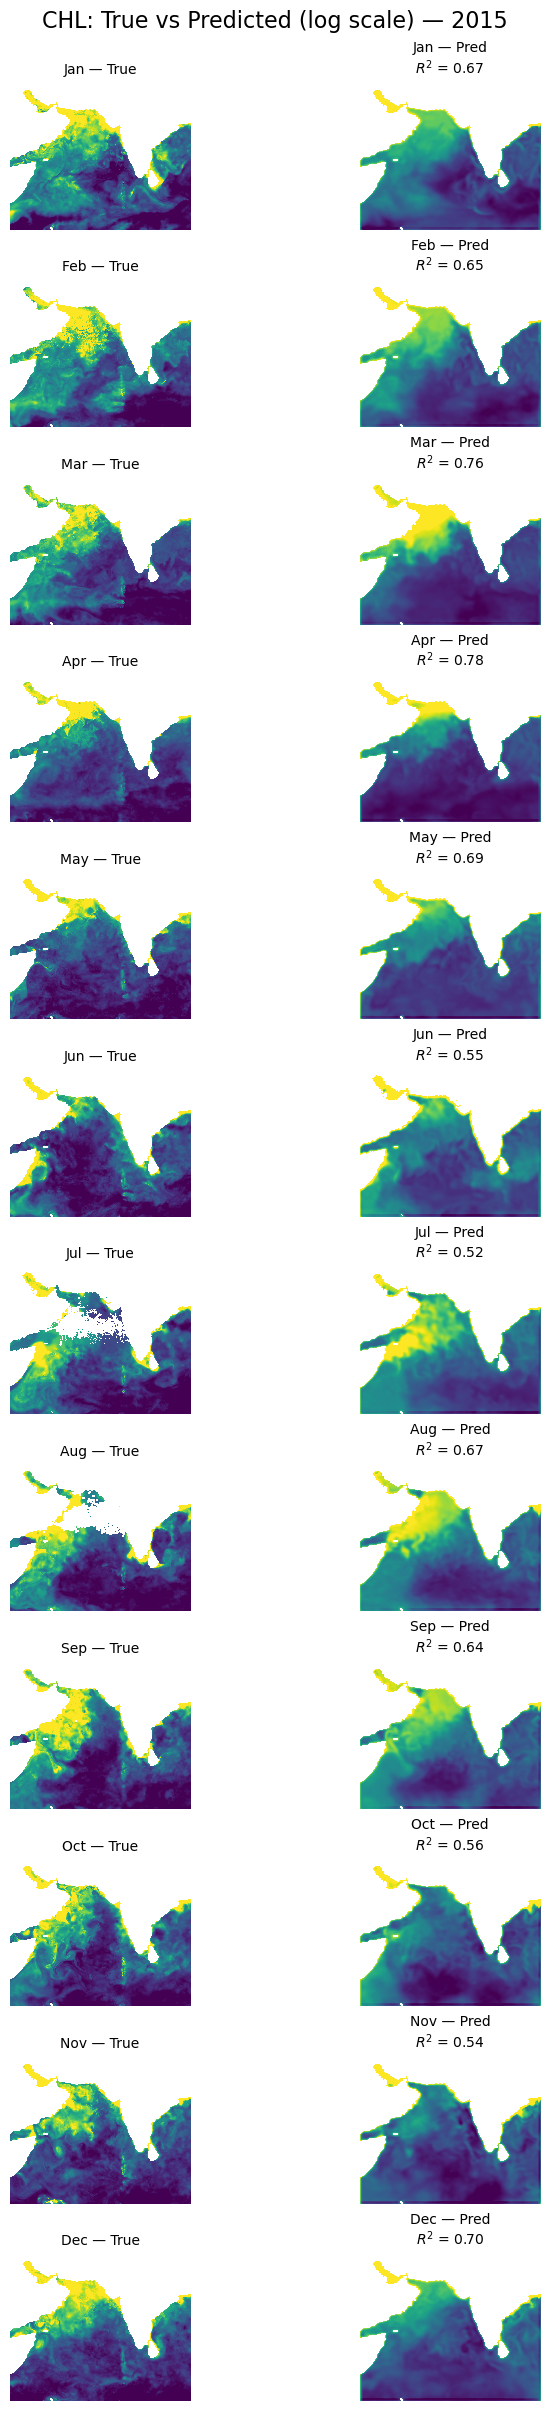

In [172]:
plot_true_vs_predicted(dataset, "2015", model, X_mean, X_std, num_var, cat_var)

## Summary

So far what we have done in Part III is no different than Part II. But we have the structure now to start training on large data sets working in batches that our memory can handle. In Part IV, we will put it together and train on multiple years. Hopefully we can improve our out of sample (different year) forecasts compared to Part II.